In [5]:
from langchain_openai import ChatOpenAI
from langchain_ollama.chat_models import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph

from typing import Literal
from dotenv import load_dotenv
from typing_extensions import Annotated, TypedDict

import os

load_dotenv()

True

In [6]:
deepseek_model = ChatOllama(
    model="nezahatkorkmaz/deepseek-v3:latest",
    base_url=os.environ.get("LLAMA_URL"),
    temperature=2,
)
mixtral_model = ChatOllama(
    model="dolphin-mixtral:latest", base_url=os.environ.get("LLAMA_URL"), temperature=2
)
llama3_model = ChatOllama(
    model="llama3.2:3b", base_url=os.environ.get("LLAMA_URL"), temperature=2
)
gpt_model = ChatOpenAI(temperature=1, model="gpt-4o-mini")

llm = gpt_model

In [7]:
class Configuration(TypedDict, total=False):
    max_depth: int
    max_candidates: int


def _ensure_configurable(config: RunnableConfig) -> Configuration:
    """Get params that configure the search algorithm."""
    configurable = config.get("configurable", {})
    return {
        **configurable,
        "max_depth": configurable.get("max_depth", 5),
        "max_candidates": configurable.get("max_candidates", 2),
    }

In [8]:
from pydantic import BaseModel
from langchain_core.prompts import PromptTemplate
from langgraph.graph import MessagesState, START, END
from operator import add


class ThoughtSchema(BaseModel):
    thought: str
    finish: bool


thinker_template = """
{{ system_prompt }}.

Before executing the task, think deeply about the next step to solve the task given by the user.
The tought you will give is the step of how to complete given by the user task.
The purpose of the thoughts is to break the problem into smaller steps.
Already taken steps: 
{% if steps %}{{ steps }}{% else %}This is your first step to solve this problem.{% endif %}

What is the next step to solve this problem? Is it the last step thast must be taken to complete the task?
Return only the next step in one sentence.
"""

thinker_prompt = PromptTemplate(
    template=thinker_template,
    input_variables=["system_prompt", "intermediate_steps"],
    template_format="jinja2",
)

system_prompt = "You are helpful code assistant."

In [9]:
user_prompt = "Create pacman game in python"

## ToT


In [10]:
class TreeNode:
    def __init__(self, thought, finish=False, score=None):
        self.thought = thought
        self.finish = finish
        self.score = score
        self.children = []

    def add_child(self, thought, finish=False, score=None):
        """Add a child node with the given thought, finish status, and score"""
        child = TreeNode(thought, finish, score)
        self.children.append(child)
        return child

    def remove_child(self, thought):
        """Remove a direct child node with the given thought"""
        for i, child in enumerate(self.children):
            if child.thought == thought:
                return self.children.pop(i)
        return None

    def __str__(self, level=0):
        """String representation of the node and its children with indentation"""
        score_str = f", score: {self.score}" if self.score is not None else ""
        result = (
            "  " * level
            + f"{{thought: '{self.thought}', finish: {self.finish}{score_str}}}\n"
        )
        for child in self.children:
            result += child.__str__(level + 1)
        return result

    def is_leaf(self):
        """Check if the node is a leaf node (has no children)"""
        return len(self.children) == 0


class ThoughtTree:
    def __init__(self, root_thought="Root", root_score=None):
        """Initialize the tree with a root node"""
        self.root = TreeNode(root_thought, score=root_score)

    def find_node(self, thought, node=None):
        """Find a node with the given thought"""
        if node is None:
            node = self.root

        if node.thought == thought:
            return node

        for child in node.children:
            result = self.find_node(thought, child)
            if result:
                return result

        return None

    def find_parent(self, thought, node=None, parent=None):
        """Find the parent of a node with the given thought"""
        if node is None:
            node = self.root

        # Check if any of this node's children match the target
        for child in node.children:
            if child.thought == thought:
                return node

        # Recursively check all children
        for child in node.children:
            result = self.find_parent(thought, child, node)
            if result:
                return result

        return None

    def add_thought(self, parent_thought, new_thought, finish=False, score=None):
        """Add a thought node as a child of the parent thought node with optional score"""
        parent = self.find_node(parent_thought)
        if parent:
            return parent.add_child(new_thought, finish, score)
        else:
            raise ValueError(f"Parent thought '{parent_thought}' not found in the tree")

    def set_score(self, thought, score):
        """Set the score for a node"""
        node = self.find_node(thought)
        if node:
            node.score = score
        else:
            raise ValueError(f"Thought '{thought}' not found in the tree")

    def get_score(self, thought):
        """Get the score for a node"""
        node = self.find_node(thought)
        if node:
            return node.score
        else:
            raise ValueError(f"Thought '{thought}' not found in the tree")

    def get_highest_scoring_nodes(self, count=1):
        """Return the highest scoring nodes"""
        nodes_with_scores = []

        def collect_scored_nodes(node):
            if node.score is not None:
                nodes_with_scores.append((node.thought, node.score))
            for child in node.children:
                collect_scored_nodes(child)

        collect_scored_nodes(self.root)
        # Sort by score in descending order
        sorted_nodes = sorted(nodes_with_scores, key=lambda x: x[1], reverse=True)
        return sorted_nodes[:count]

    def remove_node(self, thought, preserve_children=True):
        """
        Remove a node from the tree

        Args:
            thought: The thought content of the node to remove
            preserve_children: If True, the children of the removed node
                              will be attached to the parent of the removed node.
                              If False, the entire subtree will be removed.

        Returns:
            The removed node
        """
        # Cannot remove the root node
        if thought == self.root.thought:
            raise ValueError("Cannot remove the root node")

        # Find the parent of the node to remove
        parent = self.find_parent(thought)
        if not parent:
            raise ValueError(f"Thought '{thought}' not found in the tree")

        # Find the node to remove
        node_to_remove = None
        for i, child in enumerate(parent.children):
            if child.thought == thought:
                node_to_remove = parent.children.pop(i)
                break

        # If we want to preserve the children, attach them to the parent
        if preserve_children and node_to_remove:
            for child in node_to_remove.children:
                parent.children.append(child)

        return node_to_remove

    def mark_as_finished(self, thought):
        """Mark a thought node as finished"""
        node = self.find_node(thought)
        if node:
            node.finish = True
        else:
            raise ValueError(f"Thought '{thought}' not found in the tree")

    def get_leaf_nodes(self):
        """Return all leaf nodes (nodes with no children)"""
        leaves = []

        def collect_leaves(node):
            if node.is_leaf():
                leaf_data = {"thought": node.thought, "finish": node.finish}
                if node.score is not None:
                    leaf_data["score"] = node.score
                leaves.append(leaf_data)
            else:
                for child in node.children:
                    collect_leaves(child)

        collect_leaves(self.root)
        return leaves

    def get_all_paths(self):
        """Return all paths from root to each leaf node or finished node"""
        all_paths = []

        def dfs(node, current_path):
            # Add current node to the path
            node_data = {"thought": node.thought, "finish": node.finish}
            if node.score is not None:
                node_data["score"] = node.score
            current_path.append(node_data)

            # If it's a leaf node or a finished node, add the path to all_paths
            if node.is_leaf() or node.finish:
                all_paths.append(current_path.copy())

            # Continue DFS for each child
            for child in node.children:
                dfs(child, current_path.copy())

        # Start DFS from root
        dfs(self.root, [])
        return all_paths

    def get_finished_paths(self):
        """Return all paths that end with a finished node"""
        all_paths = self.get_all_paths()
        return [path for path in all_paths if path[-1]["finish"]]

    def get_not_finished_paths(self):
        """Return all paths that end with a finished node"""
        all_paths = self.get_all_paths()
        return [
            path
            for path in all_paths
            if not path[-1]["finish"] or "score" not in path[-1]
        ]

    def are_all_paths_finished(self):
        return len(self.get_all_paths()) == len(self.get_finished_paths())

    def get_highest_scoring_path(self):
        """Return the path with the highest cumulative score"""
        all_paths = self.get_all_paths()

        if not all_paths:
            return None

        # Calculate sum of scores for each path (ignoring nodes without scores)
        path_scores = []
        for path in all_paths:
            total_score = sum(node.get("score", 0) for node in path)
            path_scores.append((path, total_score))

        # Return the path with the highest total score
        return max(path_scores, key=lambda x: x[1])

    def __str__(self):
        """String representation of the entire tree"""
        return str(self.root)

    def to_dict(self):
        """Convert the tree to a dictionary for serialization"""

        def node_to_dict(node):
            node_dict = {
                "thought": node.thought,
                "finish": node.finish,
                "score": node.score,
                "children": [node_to_dict(child) for child in node.children],
            }
            return node_dict

        return {"root": node_to_dict(self.root)}

    @classmethod
    def from_dict(cls, data):
        """Create a ThoughtTree from a dictionary"""
        tree = cls(
            root_thought=data["root"]["thought"], root_score=data["root"]["score"]
        )

        def add_children(parent_node, children_data):
            for child_data in children_data:
                child = parent_node.add_child(
                    child_data["thought"], child_data["finish"], child_data["score"]
                )
                add_children(child, child_data["children"])

        add_children(tree.root, data["root"]["children"])
        return tree

In [11]:
class ToTState(MessagesState):
    tree: dict
    propositions: list[ThoughtSchema]
    goal: str
    depth: Annotated[int, add]
    intermediate_steps: list[str]


def create_goal(state: ToTState) -> ToTState:
    output = llm.invoke(
        [
            (
                "system",
                "State the goal of the user. In one short sentece. Tell what is the user intention.",
            ),
            state["messages"][-1],
        ]
    ).content
    return {"goal": output}


def reasoning_node(state: ToTState) -> ToTState:
    if "tree" in state and state["tree"]:
        propositions = []
        for path in ThoughtTree.from_dict(state.get("tree")).get_not_finished_paths():
            formatted_prompt = thinker_prompt.format(
                system_prompt=system_prompt,
                steps="\n".join(
                    [f"{n+1}. {thought['thought']}" for n, thought in enumerate(path)]
                ),
            )
            prompts = [
                [("system", formatted_prompt), state["messages"][-1]] for _ in range(5)
            ]
            thoughts = llm.with_structured_output(ThoughtSchema).batch(prompts)
            thoughts = [t.model_dump() for t in thoughts]
            propositions.append(thoughts)

        return {"propositions": propositions, "depth": 1}
    else:
        formatted_prompt = thinker_prompt.format(system_prompt=system_prompt)
        prompts = [
            [("system", formatted_prompt), state["messages"][-1]] for _ in range(5)
        ]

        thoughts = llm.with_structured_output(ThoughtSchema).batch(prompts)
        thoughts = [t.model_dump() for t in thoughts]

        return {"propositions": [thoughts], "depth": 0}


def build_tree(state: ToTState) -> ToTState:
    propositions = state.get("propositions", [[]])
    if "tree" in state:
        tree = ThoughtTree.from_dict(state.get("tree"))
    else:
        tree = ThoughtTree(state["goal"])

    for leaf, propositions_for_leaf in zip(tree.get_leaf_nodes(), propositions):
        for prop in propositions_for_leaf:
            tree.add_thought(leaf["thought"], prop["thought"], prop["finish"])
    return {"tree": tree.to_dict(), "depth": 0}


def score_and_prune(state: ToTState, config: RunnableConfig) -> ToTState:
    class Scores(BaseModel):
        score: int
        reason: str

    tree = ThoughtTree.from_dict(state.get("tree"))
    config = _ensure_configurable(config)
    system_prompt = (
        "Your task is to critisize the plan for achieving given goal."
        "Assign points from 1 to 10."
    )
    prompts = []
    paths = tree.get_not_finished_paths()

    for path in paths:
        steps = "\n".join(
            [f"{n+1}. {thought['thought']}" for n, thought in enumerate(path)]
        )
        prompts.append(
            [
                ("system", system_prompt),
                (
                    "user",
                    "Goal: "
                    "{goal} \n"
                    "Plan:"
                    "{plan}".format(goal=state["goal"], plan=steps),
                ),
            ]
        )
    scores = llm.with_structured_output(Scores).batch(prompts)
    scores = [s.model_dump()["score"] for s in scores]

    paths_scores = list(zip(paths, scores))
    paths_scores_sorted = list(sorted(paths_scores, key=lambda x: x[-1], reverse=True))

    for path, score in paths_scores_sorted[: config.get("max_candidates")]:
        tree.set_score(path[-1]["thought"], score)

    for path, _ in paths_scores_sorted[config.get("max_candidates") :]:
        tree.remove_node(path[-1]["thought"])

    return {"tree": tree.to_dict(), "depth": 0}


def should_continue(
    state: ToTState, config: Configuration
) -> Literal["format_response", "reasoning_node"]:
    config = _ensure_configurable(config)
    if ThoughtTree.from_dict(state["tree"]).are_all_paths_finished() or state[
        "depth"
    ] >= config.get("max_depth"):
        return "format_response"
    return "reasoning_node"


def format_response(state: ToTState):
    return {
        "intermediate_steps": [
            t["thought"]
            for t in ThoughtTree.from_dict(state["tree"]).get_highest_scoring_path()[0]
        ]
    }

In [12]:
graph_builder = StateGraph(ToTState, config_schema=Configuration)

graph_builder.add_node("create_goal", create_goal)
graph_builder.add_node("reasoning_node", reasoning_node)
graph_builder.add_node("build_tree", build_tree)
graph_builder.add_node("score_and_prune", score_and_prune)
graph_builder.add_node("format_response", format_response)

graph_builder.add_edge(START, "create_goal")
graph_builder.add_edge("create_goal", "reasoning_node")
graph_builder.add_edge("reasoning_node", "build_tree")
graph_builder.add_edge("build_tree", "score_and_prune")
graph_builder.add_conditional_edges(
    "score_and_prune", should_continue, ["format_response", "reasoning_node"]
)
graph_builder.add_edge("format_response", END)

tot_graph = graph_builder.compile()

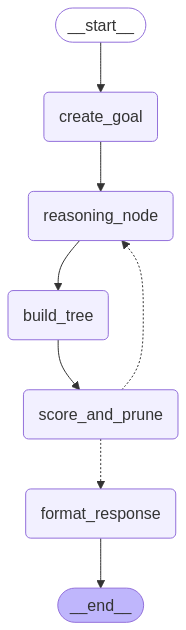

In [13]:
from IPython.display import Image, display

display(Image(tot_graph.get_graph().draw_mermaid_png()))

## Basic code agent with ToT


In [29]:
from langchain_core.prompts.chat import MessagesPlaceholder
from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command
import json
import os

coder_system_prompt = """You are coder expert. Your task is to write high quaility code. 
You get access to many of tools that helps you write code.

Always reason before executing the task
When you have the plan of executing the task, go step by step to accomplish it.
Follow the plan until it is finished.
Don't write code in one file.
"""

coder_template = ChatPromptTemplate(
    [
        ("system", coder_system_prompt),
        # ("ai", "Current state: {state}"),
        MessagesPlaceholder("messages"),
    ]
)


class ToReason(BaseModel):
    """Use this if you want to deeply reason."""

    context: str
    problem: str


@tool
def create_file(filename: str):
    """Creates a file"""
    print("creating file...")

    with open(f"./codes/{filename}", "w+") as f:
        f.write("")
    return "created"


@tool
def create_code_and_save_to_file(filename: str, code: str):
    """Saves code to the file"""
    print("saving code...")

    with open(f"./codes/{filename}", "w+") as f:
        f.write(code)
    return "done"


@tool
def read_file(filename: str):
    """Read the code from given file"""
    print("reading code...")

    with open(f"./codes/{filename}", "r") as f:
        code = f.read()
    return code


@tool
def create_directory(directory: str):
    """Create directory. It creates relative directory"""
    os.makedirs(f"./codes/{directory}")
    return "done"


tools = [create_file, create_code_and_save_to_file, read_file, create_directory]
tools += [ToReason]
tool_node = ToolNode(tools)


class CoderAgentState(MessagesState):
    current_dir: str
    intermediate_steps: list[str]


def create_entry_node(new_dialog_state: str):
    def entry_node(state: CoderAgentState) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content="Now you start reasoning.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node


def reason(state: CoderAgentState) -> CoderAgentState:
    print("reasoning...")
    args = json.loads(
        state.get("messages")[-2].additional_kwargs["tool_calls"][-1]["function"][
            "arguments"
        ]
    )
    print(args)

    steps = tot_graph.invoke(
        {
            "messages": [
                (
                    "human",
                    f"Think how to solve this problem: {args.get('problem')}. \nMore context: {args.get('context')}",
                )
            ]
        }
    ).get("intermediate_steps")

    steps = "\n".join([f"{n+1}. {step}" for n, step in enumerate(steps)])
    print("STEPS: ", steps)

    return {"messages": [AIMessage(content="Your plan to execute the task: " + steps)]}


def llm_node(state: CoderAgentState) -> CoderAgentState:
    runnable = coder_template | llm.bind_tools(tools)
    output = runnable.invoke({"messages": state.get("messages")})
    return {"messages": [output]}


def should_continue(state: CoderAgentState):
    tool_calls = state["messages"][-1].tool_calls

    if tool_calls:
        if tool_calls[-1]["name"] == ToReason.__name__:
            return "start_reasoning"
        else:
            return "tools"
    return "__end__"


coder_builder = StateGraph(CoderAgentState)

coder_builder.add_node("llm_node", llm_node)
coder_builder.add_node("reason", reason)
coder_builder.add_node("start_reasoning", create_entry_node("reason"))
coder_builder.add_node("tools", tool_node)

coder_builder.add_edge(START, "llm_node")
coder_builder.add_conditional_edges(
    "llm_node", should_continue, ["tools", "start_reasoning", "__end__"]
)
coder_builder.add_edge("start_reasoning", "reason")
coder_builder.add_edge("reason", "llm_node")
coder_builder.add_edge("tools", "llm_node")
coder = coder_builder.compile()

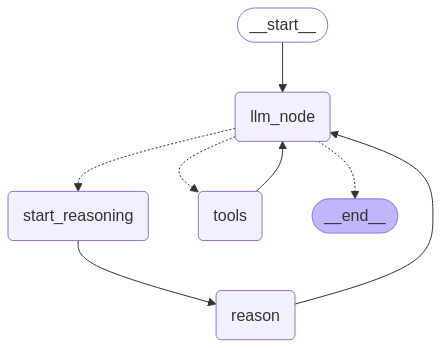

In [30]:
from IPython.display import Image, display

display(Image(coder.get_graph().draw_mermaid_png()))

In [31]:
# coder.invoke({"messages": [("human", "Create a pacman game.")]})

## Step by step coding


In [32]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver


tools = [create_file, create_code_and_save_to_file, read_file, create_directory]
tool_node = ToolNode(tools)


class CoderAgentState(MessagesState):
    current_dir: str
    intermediate_steps: list[str]
    current_step: Annotated[int, add]


def reason(state: CoderAgentState) -> CoderAgentState:
    steps = tot_graph.invoke(
        {"messages": state.get("messages")}, config={"recursion_limit": 50}
    ).get("intermediate_steps")

    formatted_steps = "\n".join([f"{n+1}. {step}" for n, step in enumerate(steps)])
    print("STEPS: ", formatted_steps)

    return {
        "messages": [HumanMessage(content="Focus on this: " + formatted_steps)],
        "intermediate_steps": steps,
    }


def llm_node(state: CoderAgentState) -> CoderAgentState:
    runnable = coder_template | llm.bind_tools(tools)
    output = runnable.invoke({"messages": state.get("messages")})
    return {"messages": [output]}


def should_continue(state: CoderAgentState):
    if len(state.get("intermediate_steps")) == state.get("current_step"):
        return "__end__"

    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        return "tools"

    return "__end__"


coder_builder = StateGraph(CoderAgentState)

coder_builder.add_node("llm_node", llm_node)
coder_builder.add_node("reason", reason)
coder_builder.add_node("tools", tool_node)

coder_builder.add_edge(START, "reason")
coder_builder.add_edge("reason", "llm_node")
coder_builder.add_conditional_edges("llm_node", should_continue, ["tools", "__end__"])
coder_builder.add_edge("tools", "llm_node")

checkpointer = MemorySaver()

coder = coder_builder.compile(checkpointer=checkpointer)

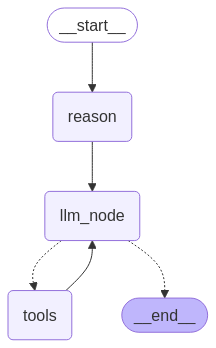

In [33]:
from IPython.display import Image, display

display(Image(coder.get_graph().draw_mermaid_png()))

In [34]:
# coder.invoke(
#     {"messages": [("human", "Create snake game in python. Save to snake directory. ")]},
#     config={"recursion_limit": 50, "thread_id": 5},
# )

In [35]:
coder.invoke(
    {
        "messages": [
            (
                "human",
                "Create a simple snake game in snake_game directory. Use Python. Make board green, snake is blue.",
            )
        ]
    },
    config={"recursion_limit": 50, "thread_id": 1},
)

STEPS:  1. The user's intention is to create a simple snake game using Python with specific color requirements for the game board and snake.
2. Set up the basic structure of the Python script and create the game window with a green background using a graphics library like Pygame.
3. Implement the game loop to handle the snake's movement, allow for user input to control the snake, and include collision detection with the game boundaries and itself.
4. Implement the snake's growth mechanism and food spawning on the game board to increase the game complexity and provide an objective for the player.
5. Implement the scoring system to track and display the player's score based on the number of food items collected by the snake.
6. The next step is to implement the rendering of the game board and the snake on the screen, ensuring the board is green and the snake is blue.
7. Write the code to render the game board with a green background and the snake with blue segments on the Pygame surface.

{'messages': [HumanMessage(content='Create a simple snake game in snake_game directory. Use Python. Make board green, snake is blue.', additional_kwargs={}, response_metadata={}, id='10fa4784-ceb5-4cc6-9e2b-7b7abcee3bd8'),
  HumanMessage(content="Focus on this: 1. The user's intention is to create a simple snake game using Python with specific color requirements for the game board and snake.\n2. Set up the basic structure of the Python script and create the game window with a green background using a graphics library like Pygame.\n3. Implement the game loop to handle the snake's movement, allow for user input to control the snake, and include collision detection with the game boundaries and itself.\n4. Implement the snake's growth mechanism and food spawning on the game board to increase the game complexity and provide an objective for the player.\n5. Implement the scoring system to track and display the player's score based on the number of food items collected by the snake.\n6. The n

In [18]:
coder.invoke(
    {
        "messages": [
            (
                "human",
                "Now it doesnt work, fix the bugs",
            )
        ]
    },
    config={"recursion_limit": 50, "thread_id": 1},
)

STEPS:  1. The user's intention is to troubleshoot and resolve issues with a malfunctioning system or code.
2. Review the error messages or issues reported to identify the specific bugs in the code that need to be fixed.
3. Debug the code by checking each function and variable to ensure they are performing as expected and making necessary adjustments based on the identified issues.
4. Run the code with debugging tools or print statements to trace the execution flow and identify the specific lines where errors occur, then apply the necessary fixes based on the observations.
5. Carefully test the code after applying fixes to ensure all issues are resolved and that the system now functions as intended without introducing new bugs.
6. Re-check the error messages or logs generated after your last changes to pinpoint any remaining issues in the code logic or syntax that need to be addressed.
7. Review the latest changes made to the code and re-execute the debugging process to identify any ne

{'messages': [HumanMessage(content='Create a simple snake game in snake2 directory.', additional_kwargs={}, response_metadata={}, id='35635fb9-ad08-47c4-a644-075aac7d6388'),
  HumanMessage(content='Focus on this: 1. The user intends to develop a basic snake game and save it in a specific directory named "snake2."\n2. Set up the project by creating the snake2 directory and initializing a basic HTML file to house the game canvas and game logic.\n3. Develop the game logic using JavaScript to define the movement of the snake, scoring system, and food generation, while integrating this logic with the HTML canvas.\n4. Implement the rendering logic to draw the snake, food, and the game board on the HTML canvas, and set up an animation loop to continuously update and render the game state.\n5. Add user input handling to control the snake\'s direction and maybe implement game-over conditions when the snake collides with itself or the walls.\n6. Test the game thoroughly to ensure smooth gameplay

In [ ]:
class Agent: ...

In [ ]:
Agent(system_prompt="asda", tool=[], reason="tot")